In [16]:
import torch
import torch.nn as nn
import numpy as np
from tc.tc_fc import TTLinear
import matplotlib.pyplot as plt
import time

import numpy as np
import torch
from torch.nn.utils import parameters_to_vector

from matplotlib import cm
import tntorch as tn
from pytorch_minimize.optim import MinimizeWrapper

In [17]:
device = 'cuda'

In [ ]:
import torch
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer

class ZO_SignSGD(Optimizer):

    # =======================================================================#
    # Since we are doing experiments with functions with available gradients,#
    # but ZO optimizers have lots of unavailable gradient applications,      #
    # we introduce a use_tru_grad flag, and set to false by default          #
    # =======================================================================#

    def __init__(self, params, model, inputs, criterion, lr=1e-3, fd_eps=1e-4, use_true_grad=False):
        self.model = model
        self.inputs = inputs
        self.criterion = criterion
        defaults = dict(lr=lr, fd_eps=fd_eps, use_true_grad=use_true_grad)
        super().__init__(params, defaults)

    def step(self):
        # print(self.param_groups)
        for group in self.param_groups:
            lr = group['lr']
            fd_eps = group['fd_eps']
            use_true_grad = group['use_true_grad']
            grad_est = self._grads(group['params'], fd_eps)
            # for i, param in enumerate(group['params']):
            #     param.data.add_(-lr * torch.sign(grad_est[i]))
            for param in group['params']:
                if param.grad is None and use_true_grad:
                    raise ValueError('ZO_SGD should be used only when gradients are not available,'
                                     'or when use_true_grad is False.')
                if use_true_grad:
                    grad_est = param.grad.data
                else:
                    grad_est = self._compute_gradient_direction(param, fd_eps)
                param.data.add_(-lr * torch.sign(grad_est))

    def _compute_gradient_direction(self, param, fd_eps):
        grad_est = torch.zeros_like(param.data)
        orig_param = param.data.clone()
        # orig_model_state = self.model.state_dict().__str__()

        # Generate a random direction for the entire parameter vector
        direction = torch.randint(0, 2, param.data.shape) * 2 - 1
        direction = direction.to(param.device)

        # Perturb the parameters along the random direction
        param.data.add_(fd_eps * direction)

        # new_model_state = self.model.state_dict().__str__()
        # if orig_model_state == new_model_state:
        #     print("+ direction: Not updated")
        # else:
        #     print("+ direction: Updated")

        # Compute the loss with the perturbed parameters
        loss_plus = self.criterion(self.model)  # Replace with our stochastic loss computation
      
        # Perturb the parameters in the opposite direction
        param.data.sub_(1 * fd_eps * direction)

        # new_model_state = self.model.state_dict().__str__()
        # if orig_model_state == new_model_state:
        #     print("- direction: Not updated")
        # else:
        #     print("- direction: Updated")
      
        # Compute the loss with the opposite perturbed parameters
        loss_ = self.criterion(self.model)  # Replace with our stochastic loss computation

        # Estimate the gradient using the finite difference approximation
        grad_est_flat = (loss_plus - loss_) / (fd_eps)

        # Assign the estimated gradient to grad_est
        grad_est = grad_est_flat / direction

        # Restore the original parameters
        param.data = orig_param.clone()
     
        return grad_est
    
    def _grads(self, params, eps):
        orig_param = [param.data.clone() for param in params]
        loss = self.criterion(self.model)
        
        N = 10
        grads = [torch.zeros_like(param) for param in model.parameters()]
        
        for i in range(N):
            direction = [(np.sqrt(eps) * torch.randn_like(param)).to(params[0].device) for param in orig_param]
            
            for param, dir in zip(params, direction):
                param.data.add_(dir)
                
            loss_plus = self.criterion(self.model)
            
            grad_est_flat = (loss_plus - loss) / (N * np.sqrt(eps))
            grad_est = list(map(lambda x: grad_est_flat * x, direction))
            
            grads = [g_cur + g for g_cur, g in zip(grads, grad_est)]
            
        for i, p in enumerate(orig_param):
            params[i].data = p.clone()
            
        return grads
    # def _grads(self, param, fd_eps):
    #     orig_param = param.data.clone()
    #     
    #     loss = self.criterion(self.model)
    #     N = 10
    #     grads = 0
    #     
    #     for i in range(N):
    #         direction = np.sqrt(fd_eps) * torch.randn_like(param.data)
    #         direction = direction.to(param.device)
    #        
    #         param.data.add_(direction)
    #         loss_plus = self.criterion(self.model)  # Replace with our stochastic loss computation
    #     
    #         grad_est_flat = (loss_plus - loss) / (N * np.sqrt(fd_eps))
    # 
    #         # Assign the estimated gradient to grad_est
    #         grad_est = grad_est_flat * direction
    #         grads += grad_est
    #     
    #     param.data = orig_param.clone()
    #  
    #     return grads

In [46]:
class ZO_SGD(Optimizer):

    # =======================================================================#
    # Since we are doing experiments with functions with available gradients,#
    # but ZO optimizers have lots of unavailable gradient applications,      #
    # we introduce a use_tru_grad flag, and set to false by default          #
    # =======================================================================#

    def __init__(self, params, model, inputs, labels, criterion, lr=1e-3, fd_eps=1e-4, use_true_grad=False):
        self.model = model
        self.inputs = inputs
        self.labels = labels
        self.criterion = criterion
        defaults = dict(lr=lr, fd_eps=fd_eps, use_true_grad=use_true_grad)
        super().__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            fd_eps = group['fd_eps']
            use_true_grad = group['use_true_grad']
            for param in group['params']:
                if param.grad is None and use_true_grad:
                    raise ValueError('ZO_SGD should be used only when gradients are not available,'
                                     'or when use_true_grad is False.')
                if use_true_grad:
                    grad_est = param.grad.data
                else:
                    grad_est = self._compute_gradient_direction(param, fd_eps)

                param.data.add_(-lr * grad_est)


    def _compute_gradient_direction(self, param, fd_eps):
        grad_est = torch.zeros_like(param.data)
        orig_param = param.data.clone()
        # orig_model_state = self.model.state_dict().__str__()

    # Generate a random direction for the entire parameter vector
        direction = torch.randint(0, 2, param.data.shape) * 2 - 1
    

        # Perturb the parameters along the random direction
        param.data.add_(fd_eps * direction)

        # new_model_state = self.model.state_dict().__str__()
        # if orig_model_state == new_model_state:
        #     print("+ direction: Not updated")
        # else:
        #     print("+ direction: Updated")

        # Compute the loss with the perturbed parameters
        loss_plus = self.criterion(self.model(self.inputs), F.one_hot(self.labels, num_classes=10).float())  # Replace with our stochastic loss computation

    # Perturb the parameters in the opposite direction
        param.data.sub_(1 * fd_eps * direction) #get back to original
      
        # new_model_state = self.model.state_dict().__str__()
        # if orig_model_state == new_model_state:
        #     print("- direction: Not updated")
        # else:
        #     print("- direction: Updated")

    # Compute the loss with the opposite perturbed parameters
        loss_ = self.criterion(self.model(self.inputs), F.one_hot(self.labels, num_classes=10).float())  # Replace with our stochastic loss computation
      
    # Estimate the gradient using the finite difference approximation
        grad_est_flat = (loss_plus - loss_) / (fd_eps)

    # Assign the estimated gradient to grad_est
        grad_est = grad_est_flat/direction

    # Restore the original parameters
        param.data = orig_param.clone()
      #print("grad_est: {:.2e}".format(grad_est))

        return grad_est

In [30]:

class ZO_AdaMM(Optimizer):

    def __init__(self, params, lr=1e-03, betas=(0.9, 0.999), mu=1e-03, eps=1e-12):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: (} - should be >= 0.0".format(lr))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter: (} - should be in [0.0, 1.0[".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter: {} - should be in [0.0, 1.0l".format(betas[1]))
        if not 0.0 <= mu < 1.0:
            raise ValueError("Invalid mu parameter: {} - should be in [0.0, 1.0l".format(mu))

        defaults = dict(lr=lr, betas=betas, mu=mu, eps=eps)
        super().__init__(params, defaults)
        # Compute the size of the parameters vector
        self.size_params = 0
        for group in self.param_groups:
            for p in group['params']:
                self.size_params += torch.numel(p)

    def step(self, closure):

        for group in self.param_groups:
            beta1, beta2 = group['betas']

            # Closure return the approximation for the gradient
            grad_est = closure(self.size_params, group["mu"])

            for p, grad in zip(group['params'], grad_est):
                state = self.state[p]

                # Lazy state initialization
                if len(state) == 0:
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                    # Maintains max of all exp. moving avg. of sq. grad. values
                    state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                # Do the AdaMM updates
                state['exp_avg'].mul_(beta1).add_(grad, alpha=(1.0 - beta1))
                state['exp_avg_sq'].mul_(beta2).addcmul_(grad, grad, value=(1.0 - beta2))
                state['max_exp_avg_sq'] = torch.maximum(state['max_exp_avg_sq'],
                                                        state['exp_avg_sq'])

                p.data.addcdiv_(state['exp_avg'], state['exp_avg_sq'].sqrt().add_(group['eps']), value=(-group['lr']))

In [31]:
def train(model, optimizer, criterion, data,
          device, nb_epochs, verbose, zo_optim=False, scheduler=None,
          record_weights=False, weights_path=None):
    """
    Train the given model.
    :param model: model to train
    :param optimizer: optimizer to use
    :param criterion: loss function
    :param training_loader: train data loader
    :param validation_loader: validation data loader
    :param device: 'cpu' or 'cuda'
    :param nb_epochs: number of epochs for training
    :param verbose: whether to print progress information
    :param zo_optim: whether ZO optimization is used
    :param scheduler: learning rate scheduler
    :param record_weights: whether to record the weights at each epoch
    :param weights_path: where to save the weights if needed
    :return: train losses, validation losses, validation accuracies, times per epoch
    """
    train_losses = []
    validation_losses = []
    validation_accuracies = []
    epoch_time = []

    if record_weights:
        # Initialize structures to record the weights
        names_sizes = [(name, p.numel()) for name, p in model.named_parameters()]
        weights_sequences = dict()
        for n, s in names_sizes:
            weights_sequences[n] = np.zeros((nb_epochs + 1, s))

        # Record the original weights before training
        for n, p in model.named_parameters():
            weights_sequences[n][0, :] = parameters_to_vector(p).to('cpu').tolist()

    if zo_optim:
        # Global running_loss
        running_loss = 0

    for epoch in range(nb_epochs):
        start = time.time()

        # Training
        model.train()
        training_loss = 0.0




        # Forward pass
        optimizer.zero_grad()
        # outputs = model(data)
        loss = criterion(model)

        if zo_optim:
            # Closure used in the ZO optimizer
            running_loss = running_loss + loss.item()

            def closure(size_params, mu):
                grad_est = []

                # Generate a random direction uniformly on the unit ball or with a gaussian distribution

                ## ---
                # The correct way to generate a uniform variable on the sphere is by generating u in this way and then projecting u onto the sphere.
                # As we did not immediately find out how to have a uniform variable on the sphere we first used the way that is not commented on.
                # We found that after doing the experiments how to do it, but after testing it did not change the performance of our algorithm,
                # so we left the first version for the sake of reproducibility.

                # u = torch.normal(mean=torch.zeros(size_params), std=1)
                ## ---
                u = 2 * (torch.rand(size_params) - 0.5)
                u.div_(torch.norm(u, "fro"))
                u = u.to(device)

                # save the state of the model
                model_init = dict(model.state_dict())
                model_init_parameters = model.parameters()

                with torch.no_grad():
                    # we add to the initial parameters a random perturbation times \mu
                    start_ind = 0
                    for param_tensor in model.parameters():
                        end_ind = start_ind + param_tensor.view(-1).size()[0]
                        param_tensor.add_(u[start_ind:end_ind].view(param_tensor.size()).float(), alpha=mu)
                        start_ind = end_ind

                # evaluation of the model and the with a random perturbation of the parameters

                loss_random = criterion(model)

                with torch.no_grad():
                    # compute the "gradient norm"
                    grad_norm = size_params * (loss_random - loss) / mu

                    start_ind = 0
                    for param_tensor in model_init_parameters:
                        end_ind = start_ind + param_tensor.view(-1).size()[0]
                        grad_est.append(grad_norm * u[start_ind:end_ind].view(param_tensor.size()))
                        start_ind = end_ind

                # reload initial state of the parameters
                model.load_state_dict(model_init)  # try to subtract the random vector to get back initial params

                return grad_est

        if not zo_optim:
            loss.backward()
            optimizer.step()
        else:
            optimizer.step(closure)

        training_loss += loss.item()

        train_losses.append(training_loss)

        epoch_time.append(time.time() - start)

        if record_weights:
            # Record the weights of the model
            for n, p in model.named_parameters():
                weights_sequences[n][epoch + 1, :] = parameters_to_vector(p).to('cpu').tolist()

        if verbose and epoch % 5 == 0:
            print(
                f'Epoch: {epoch + 1}/{nb_epochs} |train loss: {train_losses[-1]:.4f} |time: {epoch_time[-1]:.4f}')

    if record_weights:
        # Save weights sequence to file
        for n, p in weights_sequences.items():
            np.save(f'{weights_path[:-2]}_{n}_{weights_path[-1]}', p)


In [19]:
x_grid = np.linspace(0, 1, 51)
t_grid = np.linspace(0, 1, 51)

x = torch.from_numpy(x_grid)
t = torch.from_numpy(t_grid)

grid = torch.cartesian_prod(x, t).float().to(device)

def nn_autograd_simple(model, points, order,axis=0):
    points.requires_grad=True
    f = model(points).sum()
    for i in range(order):
        grads, = torch.autograd.grad(f, points, create_graph=True)
        f = grads[:,axis].sum()
    return grads[:,axis]

func_bnd1 = lambda x: 10 ** 4 * torch.sin((1 / 10) * x * (x - 1)) ** 2
bnd1 = torch.cartesian_prod(x, torch.from_numpy(np.array([0], dtype=np.float64))).float().to(device)
bndval1 = func_bnd1(bnd1[:, 0])

# du/dx (x,0) = 1e3*sin^2(x(x-1)/10)
func_bnd2 = lambda x: 10 ** 3 * torch.sin((1 / 10) * x * (x - 1)) ** 2
bnd2 = torch.cartesian_prod(x, torch.from_numpy(np.array([0], dtype=np.float64))).float().to(device)
bop2 = {
    'du/dt':
        {
            'coeff': 1,
            'du/dt': [1],
            'pow': 1,
            'var': 0
        }
}
bndval2 = func_bnd2(bnd2[:, 0])

# u(0,t) = u(1,t)
bnd3_left = torch.cartesian_prod(torch.from_numpy(np.array([0], dtype=np.float64)), t).float().to(device)
bnd3_right = torch.cartesian_prod(torch.from_numpy(np.array([1], dtype=np.float64)), t).float().to(device)
bnd3 = [bnd3_left, bnd3_right]

# du/dt(0,t) = du/dt(1,t)
bnd4_left = torch.cartesian_prod(torch.from_numpy(np.array([0], dtype=np.float64)), t).float().to(device)
bnd4_right = torch.cartesian_prod(torch.from_numpy(np.array([1], dtype=np.float64)), t).float().to(device)
bnd4 = [bnd4_left, bnd4_right]

bop4 = {
    'du/dx':
        {
            'coeff': 1,
            'du/dx': [0],
            'pow': 1,
            'var': 0
        }
}
bcond_type = 'periodic'

bconds = [[bnd1, bndval1, 'dirichlet'],
          [bnd2, bop2, bndval2, 'operator'],
          [bnd3, bcond_type],
          [bnd4, bop4, bcond_type]]

def wave_op(model, grid):
    u_xx = nn_autograd_simple(model, grid, order=2, axis=0)
    u_tt = nn_autograd_simple(model, grid, order=2, axis=1)
    a = -(1 / 4)

    op = u_tt + a * u_xx

    return op

def op_loss(operator):
    return torch.mean(torch.square(operator))

def bcs_loss(model):
    bc1 = model(bnd1)
    bc2 = nn_autograd_simple(model, bnd2, order=1, axis=1)
    bc3 = model(bnd3_left) - model(bnd3_right)
    bc4 = nn_autograd_simple(model, bnd4_left, order=1, axis=0) - nn_autograd_simple(model, bnd4_right, order=1, axis=0)
    
    loss_bc1 = torch.mean(torch.square(bc1.reshape(-1) - bndval1))
    loss_bc2 = torch.mean(torch.square(bc2.reshape(-1) - bndval2))
    loss_bc3 = torch.mean(torch.square(bc3))
    loss_bc4 = torch.mean(torch.square(bc4))
    
    loss = loss_bc1 + loss_bc2 + loss_bc3 + loss_bc4
    return loss



In [20]:
def draw_fig(model, grid):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs = grid[:, 0].detach().cpu().numpy().reshape(-1)
    ys = grid[:, 1].detach().cpu().numpy().reshape(-1)
    zs = model(grid).detach().cpu().numpy().reshape(-1)

    ax.plot_trisurf(xs, ys, zs, cmap=cm.jet, linewidth=0.2, alpha=1)

    ax.set_title("wave periodic")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$t$")

    plt.show()

In [21]:
def loss_fn(model):
    # model.load_state_dict(params)
    operator = wave_op(model, grid)
    loss = op_loss(operator) + 1000 * bcs_loss(model)
    return loss

In [33]:
# model = torch.nn.Sequential(
#         nn.Linear(2, 100),
#         nn.Tanh(),
#         nn.Linear(100, 100),
#         nn.Tanh(),
#         nn.Linear(100, 100),
#         nn.Tanh(),
#         nn.Linear(100, 1)).to(device)

In [43]:
hid = [5, 2, 5, 2]
rank = [1, 2, 2, 2, 1]

model = torch.nn.Sequential(
        nn.Linear(2, 100),
        nn.Tanh(),
        TTLinear(hid, hid, rank, activation=None),
        nn.Tanh(),
        TTLinear(hid, hid, rank, activation=None),
        nn.Tanh(),
        nn.Linear(100, 1)).to(device)



In [41]:
device

'cuda'

In [42]:
optimizer = ZO_SignSGD(model.parameters(), model, grid, loss_fn, lr = 1e-3)

for i in range(10001):
    optimizer.zero_grad()
    loss = loss_fn(model)
    if i % 1000 == 0:
        print(loss.item())
    optimizer.step()

# 13.5 min - 4k iter

16162.1103515625
4954.06591796875
4925.9658203125
4921.41455078125


KeyboardInterrupt: 

In [44]:
config = {
    "seed": 42,
    "batch_size": 128,
    "net": "scalable",
    "scale": 1.0/9,
    "opt_params": [1e-3, 0.9, 0.999, 1e-8],
    "optimizer": 'ZO-AdaMM',
    "epochs": 50,
    "dataset": "mnist",
    "zo_optim": True,
    "mu": 1e-3,
    "use_scheduler": True,
    "verbose": True
}

optimizer = ZO_AdaMM(model.parameters(), lr=config['opt_params'][0],
                             betas=(config['opt_params'][1], config['opt_params'][2]),
                             eps=config['opt_params'][3],
                             mu=config['mu'])



In [45]:
train(model,optimizer,loss_fn,grid,device,5000, True, zo_optim=True)

Epoch: 1/5000 |train loss: 16276.4668 |time: 0.0995
Epoch: 6/5000 |train loss: 15969.5205 |time: 0.0410
Epoch: 11/5000 |train loss: 15332.8545 |time: 0.0440
Epoch: 16/5000 |train loss: 14763.9990 |time: 0.0430
Epoch: 21/5000 |train loss: 14277.3311 |time: 0.0344
Epoch: 26/5000 |train loss: 13695.6924 |time: 0.0360
Epoch: 31/5000 |train loss: 13262.8252 |time: 0.0411
Epoch: 36/5000 |train loss: 12817.3623 |time: 0.0450
Epoch: 41/5000 |train loss: 12370.4326 |time: 0.0390
Epoch: 46/5000 |train loss: 11895.4727 |time: 0.0400
Epoch: 51/5000 |train loss: 11459.3750 |time: 0.0340
Epoch: 56/5000 |train loss: 11083.4355 |time: 0.0400
Epoch: 61/5000 |train loss: 10809.8418 |time: 0.0654
Epoch: 66/5000 |train loss: 10572.2500 |time: 0.0380
Epoch: 71/5000 |train loss: 10301.0566 |time: 0.0400
Epoch: 76/5000 |train loss: 10032.6543 |time: 0.0330
Epoch: 81/5000 |train loss: 9721.2471 |time: 0.0325
Epoch: 86/5000 |train loss: 9422.8330 |time: 0.0555
Epoch: 91/5000 |train loss: 9192.9512 |time: 0.035

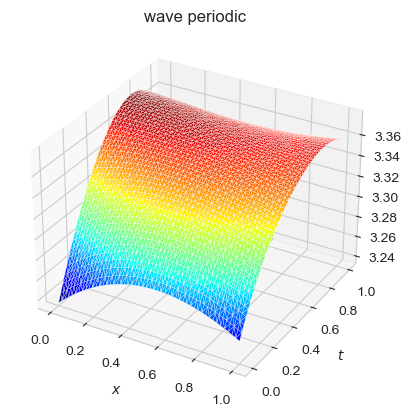

In [47]:
draw_fig(model, grid)